# Task 2 - DL - Train feature encoder

The task is to implement a Siamese Neural Network (SNN) and train it with the given dataset for face recognition. You can use any face detection solution to obtain face crops and choose any backbone architecture for your SNN.

After training the model, perform face recognition on the given image with predefined instances. The final output image must include:
bounding boxes of all the detected faces;
labels to bounding boxes: character names for recognized instances and “undefined” for unrecognized ones.


## Import necessary libraries

In [1]:
import cv2
import numpy as np
import tensorflow as tf
import zipfile
import os
from mtcnn import MTCNN
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Dropout, MaxPooling2D, Lambda, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import random
from matplotlib import pyplot as plt
from keras.metrics import BinaryAccuracy

In [2]:
# Define the size of images for training and validation
img_height = 128
img_weight = 128

In [3]:
# Path to directory with images
data_dir = 'extracted_faces'
image_size = (img_height, img_weight)

In [4]:
# Define the data augmentation generator
datagen = ImageDataGenerator(
    rescale=1./255,        # Pixel normalization to [0, 1]
    rotation_range=10,     # Random rotation within ±10 degrees
    width_shift_range=0.1, # Random horizontal shifts within 10% of the image width
    height_shift_range=0.1,# Random vertical shifts within 10% of the image height
    horizontal_flip=True,  # Random horizontal flips
    fill_mode='nearest'    # Filling strategy for pixels outside the boundaries
)

# Create a generator to load and augment images from a directory
generator = datagen.flow_from_directory(
    data_dir,               # Path to the directory containing images
    target_size=image_size, # Target size to resize images to (height, width)
    batch_size=1,           # Batch size for generating augmented images
    color_mode="rgb",       
    class_mode='sparse'     # Type of labels (sparse for integer class labels)
)

# Initialize lists to store augmented images and their labels
images = []
labels = []

# Generate and collect augmented images and labels
for _ in range(len(generator)):
    image, label = generator.next()
    image = image[0]  # Extract the image from the batch
    images.append(image)
    labels.append(int(label))

Found 6107 images belonging to 1326 classes.


In [5]:
print(len(labels), len(images))

6107 6107


In [6]:
def print_pair(images, labels, index):
    """
    Display a pair of images and their corresponding label.

    Args:
    - images: List of image pairs where each pair is a list of two images.
    - labels: List of labels corresponding to the image pairs.
    - index: Index of the pair to be displayed.

    This function displays a pair of images along with their associated label. It is commonly used
    for visualizing image pairs during the analysis of Siamese Neural Network (SNN) training or
    testing results.

    - images: A list of image pairs, where each image pair is a list containing two images.
    - labels: A list of labels, where each label corresponds to an image pair.
    - index: The index of the image pair to be displayed.

    The function prints the label and displays both images side by side using Matplotlib.
    """
    print('\nLabel:', labels[index])
    plt.imshow(images[index][0], interpolation='nearest')
    plt.show()
    
    plt.imshow(images[index][1], interpolation='nearest')
    plt.show()

In [7]:
def generate_pairs(images, labels):
    pair_images = []
    pair_labels = []

    unique_labels = list(set(labels))

    # Create a dictionary to organize images by their labels
    label_to_images = {label: [] for label in unique_labels}
    for i, label in enumerate(labels):
        label_to_images[label].append(images[i])

    for label in unique_labels:
        positive_images = label_to_images[label]
        negative_labels = [lbl for lbl in unique_labels if lbl != label]

        for anchor_image in positive_images:
            # Create positive pairs by selecting another image from the same class
            positive_pair = random.choice(positive_images)
            pair_images.append([anchor_image, positive_pair])
            pair_labels.append(1.0)  # 1 for positive pairs

            # Create negative pairs by selecting an image from a different class
            negative_label = random.choice(negative_labels)
            negative_image = random.choice(label_to_images[negative_label])
            pair_images.append([anchor_image, negative_image])
            pair_labels.append(0.0)  # 0 for negative pairs

    return np.array(pair_images), np.array(pair_labels).astype("float32")

In [8]:
pairs, pairs_labels = generate_pairs(images, labels)

In [9]:
len(pairs)

12214

In [10]:
print(pairs[0][0].shape)

(128, 128, 3)



Label: 0.0


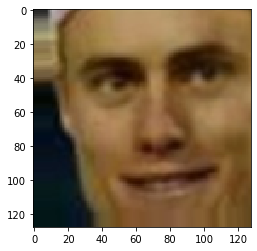

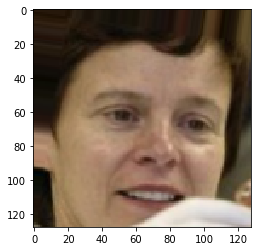

In [11]:
print_pair(pairs, pairs_labels, 12003)

In [12]:
input_shape = (img_height, img_weight, 3)

In [13]:
def base_siamese_network(input_shape):
    """
    Define the base Siamese network architecture.

    Args:
    - input_shape: Tuple representing the shape of the input images (height, width, channels).

    Returns:
    - model: A Keras Model representing the base Siamese network.

    This function defines the architecture of the base Siamese neural network, which is used to
    extract feature embeddings from input images. The architecture consists of convolutional and
    fully connected layers.

    Architecture:
    - Input layer with the specified input shape.
    - Convolutional layer with 32 filters and a 5x5 kernel, ReLU activation.
    - MaxPooling layer with 64 filters and 2x2 pooling, padding='same'.
    - Convolutional layer with 64 filters and a 4x4 kernel, ReLU activation.
    - MaxPooling layer with 32 filters and 2x2 pooling, padding='same'.
    - Convolutional layer with 64 filters and a 4x4 kernel, ReLU activation.
    - MaxPooling layer with 32 filters and 2x2 pooling, padding='same'.
    - Convolutional layer with 128 filters and a 4x4 kernel, ReLU activation.
    - Flatten layer to transform the 2D feature maps into a 1D vector.
    - Fully connected dense layer with 128 units and sigmoid activation.

    The model outputs feature embeddings that can be used for tasks like face recognition and similarity learning.
    """
    inp = Input(shape=input_shape, name='input_image')
    x = Conv2D(32, (5,5), activation='relu')(inp)
    x = MaxPooling2D(64, (2,2), padding='same')(x)
    x = Conv2D(64, (4,4), activation='relu')(x)
    x = MaxPooling2D(32, (2,2), padding='same')(x)
    x = Conv2D(64, (4,4), activation='relu')(x)
    x = MaxPooling2D(32, (2,2), padding='same')(x)
    x = Conv2D(128, (4,4), activation='relu')(x)
    x = Flatten()(x)
    x = Dense(128, activation='sigmoid')(x)
    return Model(inputs=[inp], outputs=[x], name='siamese_network')

# Create the base Siamese network model
base_model = base_siamese_network(input_shape)

# Display the model summary
base_model.summary()

Model: "siamese_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 59, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 27, 64)    

In [14]:
class L1dist(Layer):
    """
        Custom layer for computing the L1 (Manhattan) distance between two input tensors.

        Args:
        - input_image_1: The first input tensor (e.g., feature embeddings).
        - input_image_2: The second input tensor (e.g., feature embeddings).

        Returns:
        - l1_distance: The L1 distance between input_image_1 and input_image_2.

        This layer computes the element-wise absolute difference between two input tensors
        and returns the L1 distance. It can be used within a Siamese Neural Network (SNN)
        to measure the dissimilarity between pairs of data points.
    """
        
    def __init__(self, **kwargs):
        super().__init__()
        
    def call(self, input_image_1, input_image_2):
        return tf.math.abs(input_image_1 - input_image_2)

In [15]:
input_image_1 = Input(shape=input_shape)
input_image_2 = Input(shape=input_shape)

# Connect the input images to the base Siamese model to obtain embeddings
model_image_1 = base_model(input_image_1)
model_image_2 = base_model(input_image_2)

In [16]:
l1 = L1dist()

In [17]:
dist = l1(model_image_1, model_image_2)

In [18]:
print(dist)

KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='l1dist/Abs:0', description="created by layer 'l1dist'")


In [19]:
output = Dense(1, activation='sigmoid')(dist)

In [20]:
siamese_network = Model(inputs=[input_image_1, input_image_2], outputs=output, name='SNN')

In [21]:
siamese_network.summary()

Model: "SNN"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 siamese_network (Functiona  (None, 128)                  2214656   ['input_1[0][0]',             
 l)                                                                  'input_2[0][0]']             
                                                                                                  
 l1dist (L1dist)             (None, 128)                  0         ['siamese_network[0][0]',   

# Split the data into training and validation sets

In [22]:
split_ratio = 0.8  # 80% for training, 20% for validation
split_index = int(len(pairs) * split_ratio)

In [23]:
# Split data with split_index for train and val set
train_pair_images = pairs[:split_index]
train_pair_labels = pairs_labels[:split_index]
val_pair_images = pairs[split_index:]
val_pair_labels = pairs_labels[split_index:]

In [24]:
@tf.function
def contrastive_loss(y_true, y_pred, margin=1.0):
    # Compute the contrastive loss
    return tf.reduce_mean(y_true * tf.square(y_pred) + (1 - y_true) * tf.square(tf.maximum(margin - y_pred, 0)))

In [25]:
# Compile the SNN with Adam optimizer
siamese_network.compile(loss=contrastive_loss, optimizer=Adam(learning_rate=0.001),metrics=[BinaryAccuracy()])

In [36]:
# Train the Siamese network
epochs = 3
batch_size = 64

# Training loop
for epoch in range(epochs):
    for _ in range(0, len(train_pair_images), batch_size):
        batch_indices = random.sample(range(len(train_pair_images)), batch_size)
        batch_images_1 = [pair[0] for pair in train_pair_images[batch_indices]]
        batch_images_2 = [pair[1] for pair in train_pair_images[batch_indices]]
        batch_labels = train_pair_labels[batch_indices]
        
        batch_images_1 = np.array(batch_images_1)
        batch_images_1  = np.squeeze(batch_images_1)

        batch_images_2 = np.array(batch_images_2)
        batch_images_2  = np.squeeze(batch_images_2)
        
        # Apply data augmentation to each image pair in the batch
        augmented_batch_images_1 = []
        augmented_batch_images_2 = []
        
        for img_1, img_2 in zip(batch_images_1, batch_images_2):
            img_1 = datagen.random_transform(img_1)
            img_2 = datagen.random_transform(img_2)
            augmented_batch_images_1.append(img_1)
            augmented_batch_images_2.append(img_2)
        
        augmented_batch_images_1 = np.array(augmented_batch_images_1)
        augmented_batch_images_2 = np.array(augmented_batch_images_2)

        loss, accuracy = siamese_network.train_on_batch([augmented_batch_images_1, augmented_batch_images_2], batch_labels)
        print(f"Epoch {epoch+1}/{epochs}, Batch Loss: {loss}, Batch Accuracy: {accuracy}")
        siamese_network.save('SNN-f.h5')
        
    # Optionally, evaluate the Siamese network on the validation set
    val_loss, val_accuracy = siamese_network.evaluate([np.squeeze(val_pair_images[:, 0]), np.squeeze(val_pair_images[:, 1])], val_pair_labels)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss}, Accuracy: {accuracy}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")


Epoch 1/3, Batch Loss: 0.24556763470172882, Batch Accuracy: 0.4375
Epoch 1/3, Batch Loss: 0.2464689463376999, Batch Accuracy: 0.390625
Epoch 1/3, Batch Loss: 0.24741539359092712, Batch Accuracy: 0.515625
Epoch 1/3, Batch Loss: 0.2591681480407715, Batch Accuracy: 0.5625
Epoch 1/3, Batch Loss: 0.24295949935913086, Batch Accuracy: 0.4375
Epoch 1/3, Batch Loss: 0.2490471750497818, Batch Accuracy: 0.5
Epoch 1/3, Batch Loss: 0.23627689480781555, Batch Accuracy: 0.4375
Epoch 1/3, Batch Loss: 0.2582288682460785, Batch Accuracy: 0.484375
Epoch 1/3, Batch Loss: 0.2601713240146637, Batch Accuracy: 0.546875
Epoch 1/3, Batch Loss: 0.24852339923381805, Batch Accuracy: 0.421875
Epoch 1/3, Batch Loss: 0.251298725605011, Batch Accuracy: 0.5
Epoch 1/3, Batch Loss: 0.2495099902153015, Batch Accuracy: 0.484375
Epoch 1/3, Batch Loss: 0.24436859786510468, Batch Accuracy: 0.390625
Epoch 1/3, Batch Loss: 0.24796895682811737, Batch Accuracy: 0.46875
Epoch 1/3, Batch Loss: 0.24520240724086761, Batch Accuracy: 0


Label: 0.0


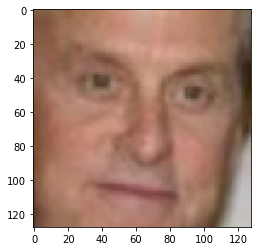

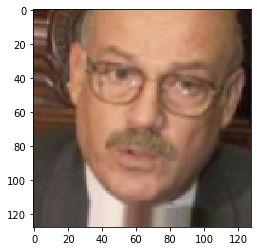

1/1 [==============================] - 0s 385ms/step


array([[0.5049945]], dtype=float32)

In [42]:
# Test model predictions
num = 667
print_pair(pairs, pairs_labels, num)
s1 = np.expand_dims(pairs[num][0], axis=0)
s2 = np.expand_dims(pairs[num][1], axis=0)
siamese_network.predict([s1, s2])

In [43]:
name_mapping = {
    0 : 'Michael Scott',
    1: 'Oscar Martinez',
    2: 'Dwight Shrute',
    3: 'Pam Beesly',
    4: 'Jim Halpert',
    5: 'Angela Martin',
    6: 'Kelly Kapoor',
    7: 'Stanley Hudson',
    8: 'Kevin Malone',
    9: 'Meredith Palmer',
    10: 'Creed Bratton',
}

In [44]:
input_dir = '2_inference_data/instances'
characters = []

In [45]:
for filename in os.listdir(input_dir):
    if filename.endswith('.jpg'):
        input_path = os.path.join(input_dir, filename)
        img = cv2.imread(input_path)
        img = cv2.resize(img, (128, 128))
        characters.append(img)

In [55]:

# Initialize the MTCNN face detection model
mtcnn = MTCNN()

# Load an image from a file
image = cv2.imread('demo_image.jpg')

# Detect faces using the MTCNN model
faces = mtcnn.detect_faces(image)

for result in faces:
    x, y, w, h = result['box']  # Extract face bounding box coordinates
    face = image[y:y+h, x:x+w]  # Crop the detected face from the image

    face = cv2.resize(face, (128, 128))
    face = (1. * face) /  255            # Normalize image
    face = np.expand_dims(face, axis=0)  # Add a batch dimension to the face
    print(face)

    pred = []

    
    # Compare the detected face with known characters using the Siamese network
    for i in range(len(characters)):
        pred.append(siamese_network.predict([face, np.expand_dims(characters[i], axis=0)]).astype('float32'))

    max_index = np.argmax(pred)

    # Determine the label based on the prediction
    if pred[max_index] < 0.5:
        label = "Undefined" 
    else:
        # Perform face recognition by comparing the embedding to known individuals
        recognized_name = name_mapping[max_index]
        label = f"{recognized_name}"

    # Draw a bounding box around the detected face and display the label
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)


2/2 [==============================] - 0s 30ms/step
[[[[0.15686275 0.12941176 0.09411765]
   [0.15294118 0.1254902  0.09019608]
   [0.14509804 0.12156863 0.08627451]
   ...
   [0.17254902 0.14901961 0.10196078]
   [0.17647059 0.14117647 0.10196078]
   [0.17647059 0.14117647 0.10196078]]

  [[0.16078431 0.13333333 0.09803922]
   [0.15686275 0.12941176 0.09411765]
   [0.15294118 0.1254902  0.09019608]
   ...
   [0.17254902 0.14901961 0.10196078]
   [0.17647059 0.14901961 0.10196078]
   [0.18039216 0.14509804 0.10196078]]

  [[0.16470588 0.1372549  0.10196078]
   [0.16470588 0.1372549  0.10196078]
   [0.16078431 0.12941176 0.09411765]
   ...
   [0.17254902 0.15294118 0.09803922]
   [0.18431373 0.15686275 0.10588235]
   [0.18823529 0.15686275 0.10588235]]

  ...

  [[0.07058824 0.04313725 0.03529412]
   [0.0745098  0.04313725 0.03137255]
   [0.07843137 0.04705882 0.03137255]
   ...
   [0.05882353 0.04705882 0.0627451 ]
   [0.05882353 0.03921569 0.05490196]
   [0.05490196 0.03529412 0.05490

In [56]:
# Display the result image
cv2.imshow('Face Recognition Result', image)
cv2.waitKey(0)
cv2.destroyAllWindows()